In [6]:
# imports
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
import pdb
import subprocess
import re
import datetime
%matplotlib inline

In [7]:
now = datetime.datetime.now().strftime("ICs_%Y_%m_%d_%H%M%S")
now

'ICs_2017_08_27_153445'

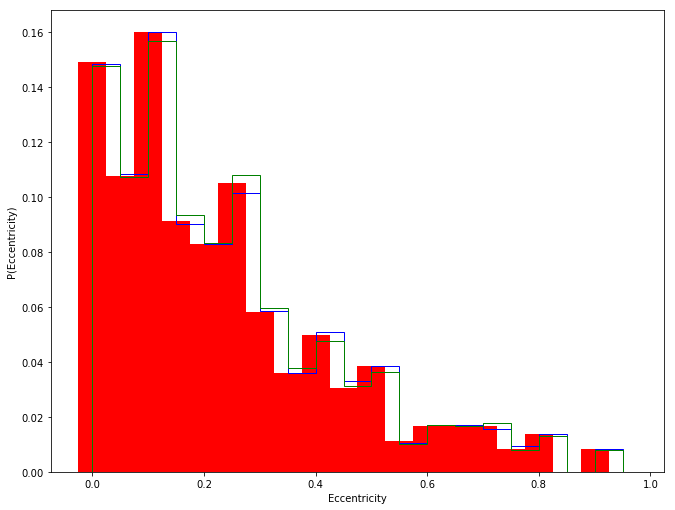

In [8]:
#generates ecc,for b,c
#ALL NOT HILL STABLE

data = QTable.read('probecc_comma.dat',format='ascii.no_header')

data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

# generates a distribution of 't' eccentricities fitted to the kepler distribution
def ecc_gen(t): # t = number of simulations
    n = 0
    ecc_list = np.array([])
    while n <= t-1:
        r = (np.random.sample(1)) #some y value (percentage)
        if r <= 0.149171270718232:
            bin_lower=0.0
            bin_upper=0.05
        else:
            r_mask = np.where(y<=r)
            x_below = x[r_mask]
            x_below = np.append(x_below,x_below[-1]+0.05)
            bin_upper = x_below[-1]+0.05
            bin_lower = x_below[-2]+0.05
        rand = np.random.uniform(0,0.05,1)
        ecc = bin_lower + rand 
        ecc_list=np.append(ecc_list,ecc)
        n += 1
        continue
    return ecc_list

# function to calc mass and Q based on radius; call for b.in and c.in
def calc_mass_Qp(radius,toggle):
    r = radius
    R_crit = 2*u.earthRad
    if r < R_crit:
        mass = ((r/const.R_earth)**(3.68))*const.M_earth
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        r = r.to(u.cm)
        volume = (4*np.pi*r**3)/3
        density = (1*u.g)/(1*u.cm)**3
        mass = volume * density
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    if toggle == 'm':
        return mass
    elif toggle == 'Q':
        return Qplanet


t = 25000 # number of sims

ecc_b = ecc_gen(t)
ecc_c = ecc_gen(t)

ecc_hist_b = ax.hist(ecc_b,bins=x,weights=np.zeros_like(ecc_b)+1./ecc_b.size,histtype='step',color='blue')
ecc_hist_c = ax.hist(ecc_c,bins=x,weights=np.zeros_like(ecc_c)+1./ecc_c.size,histtype='step',color='green')


fig.savefig('IC_figs/ecc_dist.png')

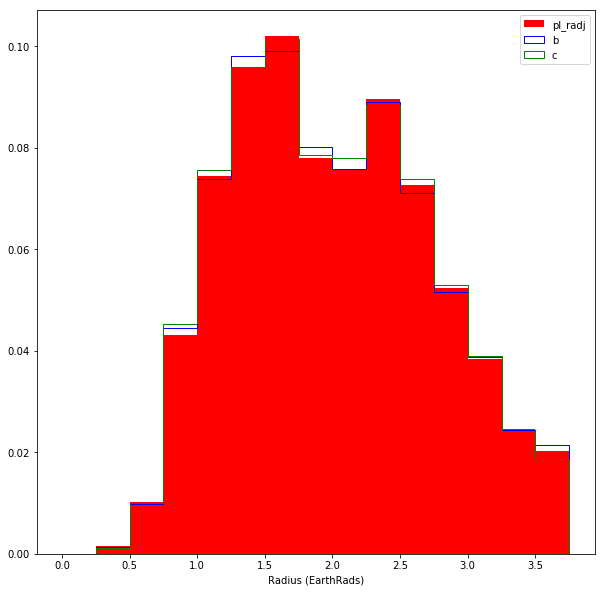

In [9]:
# generates radii from radius distribution taken from confirmed exoplanets

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
exo_data = QTable.read('planets.csv', format='ascii')
exo_data['pl_radj'] = exo_data['pl_radj'] * (const.R_jup/const.R_earth)
rad_data = exo_data['pl_radj']

x = np.arange(0,4,0.25)
rad_dist = ax.hist(rad_data,bins=x,weights=np.zeros_like(rad_data)+1./rad_data.size, color='red')
y = rad_dist[0].cumsum()

t = 25000
def rad_gen(t): # t = number of simulations
    n = 0
    rad_list = np.array([])
    while n <= t-1:
        r = (np.random.sample(1)) #some y value (percentage)
        if r <= rad_dist[0][0]:
            bin_lower=0.0
            bin_upper=0.25
        else:
            r_mask = np.where(y<=r)
            x_below = x[r_mask]
            x_below = np.append(x_below,x_below[-1]+0.25)
            bin_upper = x_below[-1]+0.25
            bin_lower = x_below[-2]+0.25
        rand = np.random.uniform(0,0.25,1)
        rad = bin_lower + rand 
        rad_list=np.append(rad_list,rad)
        n += 1
        continue
    return rad_list

rad_b = rad_gen(t)
rad_c = rad_gen(t)

rad_b_hist = ax.hist(rad_b,bins=x,weights=np.zeros_like(rad_b)+1./rad_b.size,histtype='step',color='blue', label = 'b')
rad_c_hist = ax.hist(rad_c,bins=x,weights=np.zeros_like(rad_c)+1./rad_c.size,histtype='step',color='green', label='c')
ax.set_xlabel('Radius (EarthRads)')
ax.legend(loc=0)

fig.savefig('IC_figs/rad_dist.png')

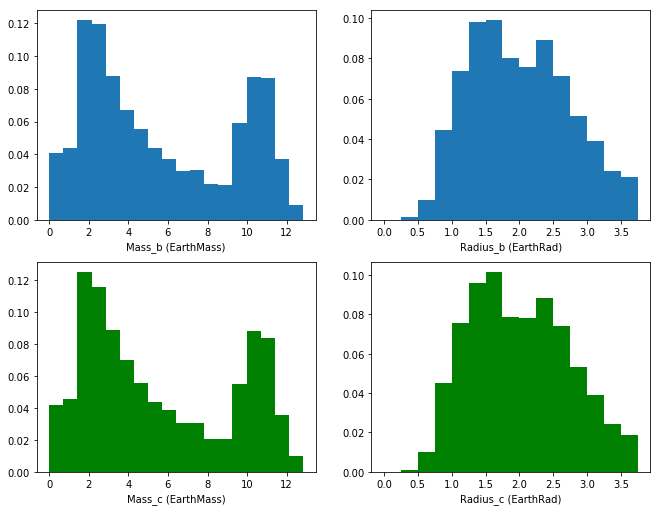

In [10]:
# now generates Qp, semi_b, mass_b, mass_c
# clears vars and generates new randoms

# b.in
ecc_b = ecc_b
rad_b = rad_b * u.earthRad  
mass_b = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
Qp_b = np.array([])    # [30,300] # [10**6,10**7]
for r in rad_b:
    m = calc_mass_Qp(r,'m')
    mass_b = np.append(mass_b,m) 
    q = calc_mass_Qp(r,'Q')
    Qp_b = np.append(Qp_b,q)
semi_b = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU

# c.in
ecc_c = ecc_c
rad_c = rad_c * u.earthRad
mass_c = np.array([])
Qp_c = np.array([])
for r in rad_c:
    m = calc_mass_Qp(r,'m')
    mass_c = np.append(mass_c,m) 
    q = calc_mass_Qp(r,'Q')
    Qp_c = np.append(Qp_c,q)

semi_c = semi_b


# star.in
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = stellar_mass * 0.0048 #[0.7,1.4] R_sun
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]

#vpl.in
Ages = 10e09

#convert to values so its easy to write to file
rad_b = rad_b.value
rad_c = rad_c.value
mass_b = mass_b.value
mass_c = mass_c.value

#graphs of b.in parameters        
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_b)-min(mass_b)
ax[0,0].hist(mass_b, bins=18, weights=np.zeros_like(mass_b)+1./mass_b.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_b, bins=x, weights=np.zeros_like(rad_b)+1./rad_b.size)


ax[0,0].set_xlabel('Mass_b (EarthMass)')
ax[0,1].set_xlabel('Radius_b (EarthRad)')



# distributions for c.in of mass, Radius. 

ran = max(mass_c)-min(mass_c)
ax[1,0].hist(mass_c, bins=18, weights=np.zeros_like(mass_c)+1./mass_c.size, color = 'green') # 18 bins --> binwidth ~10 earthMass
ax[1,1].hist(rad_c, bins = x, weights=np.zeros_like(rad_c)+1./rad_c.size, color = 'green') 


ax[1,0].set_xlabel('Mass_c (EarthMass)')
ax[1,1].set_xlabel('Radius_c (EarthRad)')

fig.savefig('IC_figs/mass_rad_dist.png')

In [12]:
max(stellar_radius)

0.0067199589156206703

In [ ]:
# makes the above parameters hill stable, as well as generates more parameters
# CAUTION: THIS BLOCK OF CODE DELETES THE ENTIRE RUNS DIRECTORY
# RUN THIS CODE ONLY TO GENERATE NEW SET OF HILL STABLE PARAMETERS

runs_dir = '/home/dm1681/Merging_Perts/Research/Merging_Perts/runs/' #directory where I want the runs to be stored

semi_c = np.copy(semi_b) # start with b and c at same distance

#fills the following lists:
hill_list = np.array([])
mean_an_b_list = np.array([])
mean_an_c_list = np.array([])
incl_b = np.array([])
incl_c = np.array([])
longa_b = np.array([])
longa_c = np.array([])
argp_b = np.array([])
argp_c = np.array([])

good_hill_list = np.array([])
bad_hill_list = np.array([])
bad_count = 0 

    
n = 0
while n <= t-1:
    name_idx = '%05i'%n
    if os.path.isdir(runs_dir) == True: #runs folder exists
        if os.path.isdir(runs_dir+name_idx) == True: #sim folders exist
            shutil.rmtree(runs_dir) #removes previous folders; THIS LINE DELETES THE ENTIRE RUNS DIRECTORY
            
    os.makedirs(runs_dir+name_idx)

    while True:
        
        #hill.in
        inc_b = 0
        inc_c = np.random.uniform(0,20)
        longasc_b = np.random.uniform(0,360)
        longasc_c = np.random.uniform(0,360)
        argperi_b = np.random.uniform(0,360)
        argperi_c = np.random.uniform(0,360)
        mean_an_b = np.random.uniform(0,360)
        mean_an_c = np.random.uniform(0,360)

        innermass_str = str(mass_b[n])
        outermass_str = str(mass_c[n])
        strMass_str = str(stellar_mass[n])
        semi_str_b = str(semi_b[n])
        semi_str_c = str(semi_c[n])
        ecc_str_b = str(ecc_b[n])
        ecc_str_c = str(ecc_c[n])

        incl_str_b = str(inc_b)
        incl_str_c = str(inc_c)
        longasc_str_b = str(longasc_b)
        longasc_str_c = str(longasc_c)
        argperi_str_b = str(argperi_b)
        argperi_str_c = str(argperi_c)
        mean_an_str_b = str(mean_an_b)
        mean_an_str_c = str(mean_an_c)

        hill = open(runs_dir+name_idx+'/hill.in','w')
        hill_content = (strMass_str+'\n'
                        +innermass_str+' '+semi_str_b+' '+ecc_str_b+' '+incl_str_b+' '+argperi_str_b+' '+longasc_str_b+' '+mean_an_str_b+'\n'
                        +outermass_str+' '+semi_str_c+' '+ecc_str_c+' '+incl_str_c+' '+argperi_str_c+' '+longasc_str_c+' '+mean_an_str_c+'\n'
                        +'body\n')
        hill.write(hill_content)
        hill.close()

        wd = runs_dir+name_idx
        #pdb.set_trace()
        hill = subprocess.call(['hillstab hill.in > hill_log'], shell=True, cwd = wd )
        hill_log = open(wd+'/hill_log','r')
        hill_content = hill_log.read()
        hill_content = hill_content.split()
        hill_exact = hill_content[1]
        hill_exact = float(hill_exact)
        if hill_exact < 1: # push out semi so that hill stab > 1
            semi_c[n] = semi_c[n] + 0.01
            continue
        elif hill_exact >= 1:
            hill_list = np.append(hill_list,hill_exact)
            incl_b = np.append(incl_b,inc_b)
            incl_c = np.append(incl_c,inc_c)
            longa_b = np.append(longa_b,longasc_b)
            longa_c = np.append(longa_c,longasc_c)
            argp_b = np.append(argp_b,argperi_b)
            argp_c = np.append(argp_c,argperi_c)
            mean_an_b_list = np.append(mean_an_b_list,mean_an_b)
            mean_an_c_list = np.append(mean_an_c_list,mean_an_c)
            good_hill_list = np.append(good_hill_list,name_idx)
            break

    n += 1
print('Hill Stability determined')

    


In [ ]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,6)

# define mask s.t. semi_c <=1
less_than_1 = np.where(semi_c <= 1)

semi_c_hist = ax.hist(semi_c[less_than_1],bins=20,weights=np.zeros_like(semi_c[less_than_1])+1./semi_c[less_than_1].size)
ax.set_xlabel('semi_c (AU)')
ax.set_ylabel('Percentage')
ax.text(0.6,0.1,'N = ' + str(semi_c[less_than_1].size),)

fig.savefig('IC_figs/semi_c_dist.png')

In [ ]:
# Parameters by file
# Variables generated above are set to new variables here, to be written to file.
runs_dir_eqonly = '/home/dm1681/Research/Research/Merging_Perts/runs_eq_only/'
runs_dir_eqorb = '/home/dm1681/Research/Research/Merging_Perts/runs_eqorb/'

def gen_eqorb(t):
    global runs_dir_eqorb, mass_b, rad_b, semi_b, ecc_b, incl_b, longa_b, argp_b, Qp_b, mass_c, rad_c, semi_c, ecc_c, incl_c, longa_c, argp_c, Qp_c, stellar_mass, stellar_radius, Qstar
    runs_dir = runs_dir_eqorb
    
    # b.in
    name_b = 'b'
    modules_b = 'eqtide distorb'
    sTideModel_b = 'p2'
    dMass_b = mass_b * -1# sets to earth masses;
    dRadius_b = rad_b * -1 # sets to earth radii
    dSemi_b = semi_b #semi_b defined above
    dEcc_b = ecc_b #ecc_b defined above
    bForceEqSpin_b = 1
    #dRotPeriod = -1 
    dObliquity_b = 45 
    dRadGyra_b = 0.5
    bInvPlane = 1 #distorb
    dInc_b = incl_b #distorb
    dLongA_b = longa_b #distorb
    dArgP_b = argp_b #distorb
    sOrbitModel_b = 'rd4' #distorb
    bOutputLapl_b = 0 #distorb
    #dPrecA_b = dPrecA_b #distrot
    #bCalcDynEllip_b = 1 #distrot
    dTidalQ_b = Qp_b 
    dK2_b = 0.3
    #dMaxLockDiff = 0.1 
    saTidePerts_b = 'star'
    saOutputOrder_b = 'Time Semim Ecce Obliquity SurfEnFluxEqtide LongP Inc LongA' #precA only for distrot, Incl and LongA for Distorb

    # c.in
    name_c = 'c'
    modules_c = 'eqtide distorb'
    sTideModel_c = 'p2'
    dMass_c = mass_c * -1 # sets to earth masses; this isnt working!!
    dRadius_c = rad_c * -1 # sets to earth radii
    dSemi_c = semi_c # semi_c defined above
    dEcc_c = ecc_c # ecc_c defined above
    bForceEqSpin_c = 1
    #dRotPeriod = -1 
    dObliquity_c = 45 
    dRadGyra_c = 0.5
    dInc_c = incl_c
    dLongA_c = longa_c
    dArgP_c = argp_c
    sOrbitModel_c = 'rd4'
    bOutputLapl_c = 0
    dTidalQ_c = Qp_c 
    dK2_c = 0.3
    #dMaxLockDiff = 0.1 
    saTidePerts_c = 'star'
    saOutputOrder_c = 'Time Semim Ecce LongP Inc LongA' #change to include Incl and LongA for Distorb runs

    #star.in
    name_star = 'star'
    modules_star = 'eqtide'
    dMass_star = stellar_mass #solar masses;
    dRadius_star = stellar_radius # * ratio of solar radii to au
    dObliquity_star = 0  
    bForceEqSpin_star = 1
    dRotPeriod_star = -30 
    dRadGyra_star = 0.5 
    dTidalQ_star = Qstar
    dK2_star = 0.3 
    saTidePerts_star = 'b c'
    saOutputOrder_s = 'Time'

    #vpl.in
    Sys_name = 'system'
    iVerbose = 5
    bOverwrite = 1
    saBodyFiles = 'star.in b.in c.in'  #c.in for distorb
    UnitMass = 'solar' 
    UnitLength = 'aU'  
    UnitTime = 'YEARS'
    UnitAngle = 'd'
    UnitTemp = 'K'
    bDoLog = 1
    iDigits = 6
    dMinValue = 10**(-10)
    bDoForward = 1
    bVarDt = 1
    dEta = 0.01
    dStopTime = 10**10
    dOutputTime = 10**9
    
    n = 0
    while n <= t-1: # will make n <= x amount of folders; (25000);
        # make strings of values; b.in
        name_idx = '%05i'%n

        if os.path.isdir(runs_dir+name_idx) == True: #sim folders exist
            shutil.rmtree(runs_dir) #removes previous folders; THIS LINE DELETES THE ENTIRE RUNS DIRECTORY
            os.makedirs(runs_dir+name_idx)
        else: #sims folder does not exist
            os.makedirs(runs_dir+name_idx)

        mass_str_b = str(dMass_b[n]) 
        radius_str_b = str(dRadius_b[n])
        eqspin_str_b = str(bForceEqSpin_b)
        obl_str_b = str(dObliquity_b)
        radgy_str_b = str(dRadGyra_b)
        ecc_str_b = str(dEcc_b[n])
        semi_str_b = str(dSemi_b[n])
        dInc_str_b = str(dInc_b[n]) # new
        dLongA_str_b = str(dLongA_b[n]) # new
        dArgP_str_b = str(dArgP_b[n]) # new
        bOutputLapl_str_b = str(bOutputLapl_b) # new
        #dPrecA_str_b = str(dPrecA_b[n]) # distrot
        #bCalcDynEllip_str_b = str(bCalcDynEllip_b) #distrot
        q_str_b = str(dTidalQ_b[n])
        dK2_str_b = str(dK2_b)
        InvPlane_str = str(bInvPlane)
        perts_str_b = str(saTidePerts_b)
        outorder_str_b = str(saOutputOrder_b)

        #c.in
        mass_str_c = str(dMass_c[n]) 
        radius_str_c = str(dRadius_c[n])
        eqspin_str_c = str(bForceEqSpin_c)
        obl_str_c = str(dObliquity_c)
        radgy_str_c = str(dRadGyra_c)
        ecc_str_c = str(ecc_c[n])
        semi_str_c = str(semi_c[n])
        dInc_str_c = str(dInc_c[n])
        dLongA_str_c = str(dLongA_c[n])
        dArgP_str_c = str(dArgP_c[n])
        q_str_c = str(dTidalQ_c[n])
        dK2_str_c = str(dK2_c)
        perts_str_c = str(saTidePerts_c)
        outorder_str_c = str(saOutputOrder_c)


        #star.in
        name_star = name_star
        modules_star = modules_star
        strMass_str = str(dMass_star[n])
        strRad_str = str(dRadius_star[n])
        strObl_str = str(dObliquity_star)
        #strEqSpin_str = str(bForceEqSpin_star)
        strRotPer_str = str(dRotPeriod_star)
        strRadGyr_str = str(dRadGyra_star)
        strTidalQ_str = str(dTidalQ_star[n])
        strdK2_str = str(dK2_star)
        saTidePerts_star = saTidePerts_star
        strsaOutputOrder = saOutputOrder_s

        #vpl.in
        sys_name = Sys_name
        iVerbose_str = str(iVerbose)
        bOverwrite_str = str(bOverwrite)
        saBodyFiles = saBodyFiles
        UnitMass = UnitMass
        UnitLength = UnitLength
        UnitTime = UnitTime
        UnitAngle = UnitAngle
        UnitTemp = UnitTemp
        bDoLog_str = str(bDoLog)
        iDigits_str = str(iDigits)
        dMinValue_str = str(dMinValue)
        bDoForward_str = str(bDoForward)
        bVarDt_str = str(bVarDt)
        dEta_str = str(dEta)
        dStopTime_str = str(int(dStopTime))
        dOutputTime_str = str(dOutputTime)


        b = open(runs_dir+name_idx+'/b.in','w')
        b_content = ('sName\t\t'+ name_b + 
                     '\nsaModules\t'+modules_b+
                     '\nsTideModel\t'+sTideModel_b+
                     '\n\ndMass\t\t'+mass_str_b+
                     '\ndRadius\t\t'+radius_str_b+
                     '\ndObliquity\t'+obl_str_b+
                     '\ndRadGyra\t'+radgy_str_b+
                     '\n\ndEcc\t\t'+ecc_str_b+
                     '\ndSemi\t\t'+semi_str_b+
                     '\n\ndInc\t\t'+dInc_str_b+
                     '\ndLongA\t\t'+dLongA_str_b+
                     '\ndArgP\t\t'+dArgP_str_b+
                     '\nsOrbitModel\t'+sOrbitModel_b+  #for Distorb
                     '\nbOutputLapl\t'+bOutputLapl_str_b+ #for Distorb
                     #'\n\ndPrecA\t'+dPrecA_str_b+     #distrot? 
                     #'\nbCalcDynEllip\t'+bCalcDynEllip_str_b+ #distrot?
                     '\n\nbForceEqSpin\t'+eqspin_str_b+
                     '\ndTidalQ\t\t'+q_str_b+
                     '\ndK2\t\t'+dK2_str_b+
                     '\nsaTidePerts\t'+perts_str_b+
                     '\n\nbInvPlane\t'+InvPlane_str+ #for Distorb
                     '\n\nsaOutputOrder\t'+outorder_str_b+'\n')
        b.write(b_content)
        b.close()

        c = open(runs_dir+name_idx+'/c.in','w')
        c_content = ('sName\t\t'+ name_c + 
                     '\nsaModules\t'+modules_c+
                     '\n\n\ndMass\t\t'+mass_str_c+
                     '\ndRadius\t\t'+radius_str_c+
                     '\ndObliquity\t'+obl_str_c+
                     '\ndRadGyra\t'+radgy_str_c+
                     '\n\ndEcc\t\t'+ecc_str_c+
                     '\ndSemi\t\t'+semi_str_c+
                     '\n\ndInc\t\t'+dInc_str_c+
                     '\ndLongA\t\t'+dLongA_str_c+
                     '\ndArgP\t\t'+dArgP_str_c+
                     '\n\nbForceEqSpin\t'+eqspin_str_c+
                     '\ndTidalQ\t\t'+q_str_c+
                     '\ndK2\t\t'+dK2_str_c+
                     '\nsaTidePerts\t'+perts_str_c+
                     '\n\nsaOutputOrder\t'+outorder_str_c+'\n')
        c.write(c_content)
        c.close()

        star = open(runs_dir+name_idx+'/star.in','w')
        star_content = ('sName\t\t'+name_star+
                        '\nsaModules\t'+modules_star+
                        '\n\ndMass\t\t'+strMass_str+
                        '\ndRadius\t\t'+strRad_str+
                        '\ndObliquity\t'+strObl_str+
                        '\ndRotPeriod\t'+strRotPer_str+
                        '\ndRadGyra\t'+strRadGyr_str+
                        '\n\ndTidalQ\t\t'+strTidalQ_str+
                        '\ndK2\t\t'+strdK2_str+
                        '\n\nsaTidePerts\t'+saTidePerts_star+
                        '\n\nsaOutputOrder\t'+strsaOutputOrder+'\n')
        star.write(star_content)
        star.close()

        vpl = open(runs_dir+name_idx+'/vpl.in','w')
        vpl_content = ('sSystemName\t'+sys_name+
                       '\niVerbose\t'+iVerbose_str+
                       '\nbOverwrite\t'+bOverwrite_str+
                       '\n\nsaBodyFiles\t'+saBodyFiles+
                       '\n\nsUnitMass\t'+UnitMass+
                       '\nsUnitLength\t'+UnitLength+
                       '\nsUnitTime\t'+UnitTime+
                       '\nsUnitAngle\t'+UnitAngle+
                       '\nsUnitTemp\t'+UnitTemp+
                       '\n\nbDoLog\t\t'+bDoLog_str+
                       '\niDigits\t\t'+iDigits_str+
                       '\ndMinValue\t'+dMinValue_str+
                       '\n\nbDoForward\t'+bDoForward_str+
                       '\nbVarDt\t\t'+bVarDt_str+
                       '\ndEta\t\t'+dEta_str+
                       '\ndStopTime\t'+dStopTime_str+
                       '\ndOutputTime\t'+ dOutputTime_str+'\n')
        vpl.write(vpl_content)
        vpl.close()

        n += 1
    IC = QTable()
    IC['Sim #'] = good_hill_list
    IC['Mass_b'] = dMass_b
    IC['Mass_c'] = dMass_c
    IC['Radius_b'] = dRadius_b
    IC['Radius_c'] = dRadius_c
    IC['Semi_b_0'] = dSemi_b
    IC['Semi_c_0'] = dSemi_c
    IC['Ecc_b_0'] = dEcc_b
    IC['Ecc_c_0'] = dEcc_c
    IC['Incl_b_0'] = dInc_b
    IC['Incl_c_0'] = dInc_c
    IC['LongA_b_0'] = dLongA_b
    IC['LongA_c_0'] = dLongA_c
    IC['ArgP_b_0'] = dArgP_b
    IC['ArgP_c_0'] = dArgP_c
    IC['Qp_b'] = dTidalQ_b
    IC['Qp_c'] = dTidalQ_c
    IC['Q_star'] = dTidalQ_star
    IC['Mass_star'] = dMass_star
    IC['Radius_star'] = dRadius_star

    IC.write('IC_table_eqorb.csv', format='ascii.csv')
    print ('IC files generated in: ' + runs_dir)

In [ ]:
def gen_eqonly(t):
    global runs_dir_eqonly, mass_b, rad_b, semi_b, ecc_b, incl_b, longa_b, argp_b, Qp_b, stellar_mass, stellar_radius, Qstar
    runs_dir = runs_dir_eqonly
    
    # b.in
    name_b = 'b'
    modules_b = 'eqtide'
    sTideModel_b = 'p2'
    dMass_b = mass_b * -1# sets to earth masses;
    dRadius_b = rad_b * -1 # sets to earth radii
    dSemi_b = semi_b #semi_b defined above
    dEcc_b = ecc_b #ecc_b defined above
    bForceEqSpin_b = 1
    #dRotPeriod = -1 
    dObliquity_b = 45 
    dRadGyra_b = 0.5
    bInvPlane = 1 #distorb
    dInc_b = incl_b #distorb
    dLongA_b = longa_b #distorb
    dArgP_b = argp_b #distorb
    sOrbitModel_b = 'rd4' #distorb
    bOutputLapl_b = 0 #distorb
    #dPrecA_b = dPrecA_b #distrot
    #bCalcDynEllip_b = 1 #distrot
    dTidalQ_b = Qp_b 
    dK2_b = 0.3
    #dMaxLockDiff = 0.1 
    saTidePerts_b = 'star'
    saOutputOrder_b = 'Time Semim Ecce Obliquity SurfEnFluxEqtide' #precA only for distrot, Incl and LongA for Distorb

    #star.in
    name_star = 'star'
    modules_star = 'eqtide'
    dMass_star = stellar_mass #solar masses;
    dRadius_star = stellar_radius # * ratio of solar radii to au
    dObliquity_star = 0  
    bForceEqSpin_star = 1
    dRotPeriod_star = -30 
    dRadGyra_star = 0.5 
    dTidalQ_star = Qstar
    dK2_star = 0.3 
    saTidePerts_star = 'b'
    saOutputOrder_s = 'Time'

    #vpl.in
    Sys_name = 'system'
    iVerbose = 5
    bOverwrite = 1
    saBodyFiles = 'star.in b.in'  #c.in for distorb
    UnitMass = 'solar' 
    UnitLength = 'aU'  
    UnitTime = 'YEARS'
    UnitAngle = 'd'
    UnitTemp = 'K'
    bDoLog = 1
    iDigits = 6
    dMinValue = 10**(-10)
    bDoForward = 1
    bVarDt = 1
    dEta = 0.01
    dStopTime = 10**10
    dOutputTime = 10**9
    
    n = 0
    while n <= t-1: # will make n <= x amount of folders; (25000);
        # make strings of values; b.in
        name_idx = '%05i'%n

        if os.path.isdir(runs_dir+name_idx) == True: #sim folders exist
            shutil.rmtree(runs_dir) #removes previous folders; THIS LINE DELETES THE ENTIRE RUNS DIRECTORY
            os.makedirs(runs_dir+name_idx)
        else: #sims folder does not exist
            os.makedirs(runs_dir+name_idx)

        mass_str_b = str(dMass_b[n]) 
        radius_str_b = str(dRadius_b[n])
        eqspin_str_b = str(bForceEqSpin_b)
        obl_str_b = str(dObliquity_b)
        radgy_str_b = str(dRadGyra_b)
        ecc_str_b = str(dEcc_b[n])
        semi_str_b = str(dSemi_b[n])
        dInc_str_b = str(dInc_b[n]) # new
        dLongA_str_b = str(dLongA_b[n]) # new
        dArgP_str_b = str(dArgP_b[n]) # new
        bOutputLapl_str_b = str(bOutputLapl_b) # new
        #dPrecA_str_b = str(dPrecA_b[n]) # distrot
        #bCalcDynEllip_str_b = str(bCalcDynEllip_b) #distrot
        q_str_b = str(dTidalQ_b[n])
        dK2_str_b = str(dK2_b)
        InvPlane_str = str(bInvPlane)
        perts_str_b = str(saTidePerts_b)
        outorder_str_b = str(saOutputOrder_b)

        #star.in
        name_star = name_star
        modules_star = modules_star
        strMass_str = str(dMass_star[n])
        strRad_str = str(dRadius_star[n])
        strObl_str = str(dObliquity_star)
        #strEqSpin_str = str(bForceEqSpin_star)
        strRotPer_str = str(dRotPeriod_star)
        strRadGyr_str = str(dRadGyra_star)
        strTidalQ_str = str(dTidalQ_star[n])
        strdK2_str = str(dK2_star)
        saTidePerts_star = saTidePerts_star
        strsaOutputOrder = saOutputOrder_s

        #vpl.in
        sys_name = Sys_name
        iVerbose_str = str(iVerbose)
        bOverwrite_str = str(bOverwrite)
        saBodyFiles = saBodyFiles
        UnitMass = UnitMass
        UnitLength = UnitLength
        UnitTime = UnitTime
        UnitAngle = UnitAngle
        UnitTemp = UnitTemp
        bDoLog_str = str(bDoLog)
        iDigits_str = str(iDigits)
        dMinValue_str = str(dMinValue)
        bDoForward_str = str(bDoForward)
        bVarDt_str = str(bVarDt)
        dEta_str = str(dEta)
        dStopTime_str = str(int(dStopTime))
        dOutputTime_str = str(dOutputTime)


        b = open(runs_dir+name_idx+'/b.in','w')
        b_content = ('sName\t\t'+ name_b + 
                     '\nsaModules\t'+modules_b+
                     '\nsTideModel\t'+sTideModel_b+
                     '\n\ndMass\t\t'+mass_str_b+
                     '\ndRadius\t\t'+radius_str_b+
                     '\ndObliquity\t'+obl_str_b+
                     '\ndRadGyra\t'+radgy_str_b+
                     '\n\ndEcc\t\t'+ecc_str_b+
                     '\ndSemi\t\t'+semi_str_b+
                     '\n\ndInc\t\t'+dInc_str_b+
                     '\ndLongA\t\t'+dLongA_str_b+
                     '\ndArgP\t\t'+dArgP_str_b+
                     #'\nsOrbitModel\t'+sOrbitModel_b+  #for Distorb
                     #'\nbOutputLapl\t'+bOutputLapl_str_b+ #for Distorb
                     #'\n\ndPrecA\t'+dPrecA_str_b+     #distrot? 
                     #'\nbCalcDynEllip\t'+bCalcDynEllip_str_b+ #distrot?
                     '\n\nbForceEqSpin\t'+eqspin_str_b+
                     '\ndTidalQ\t\t'+q_str_b+
                     '\ndK2\t\t'+dK2_str_b+
                     '\nsaTidePerts\t'+perts_str_b+
                     #'\n\nbInvPlane\t'+InvPlane_str+ #for Distorb
                     '\n\nsaOutputOrder\t'+outorder_str_b+'\n')
        b.write(b_content)
        b.close()
        
        star = open(runs_dir+name_idx+'/star.in','w')
        star_content = ('sName\t\t'+name_star+
                        '\nsaModules\t'+modules_star+
                        '\n\ndMass\t\t'+strMass_str+
                        '\ndRadius\t\t'+strRad_str+
                        '\ndObliquity\t'+strObl_str+
                        '\ndRotPeriod\t'+strRotPer_str+
                        '\ndRadGyra\t'+strRadGyr_str+
                        '\n\ndTidalQ\t\t'+strTidalQ_str+
                        '\ndK2\t\t'+strdK2_str+
                        '\n\nsaTidePerts\t'+saTidePerts_star+
                        '\n\nsaOutputOrder\t'+strsaOutputOrder+'\n')
        star.write(star_content)
        star.close()

        vpl = open(runs_dir+name_idx+'/vpl.in','w')
        vpl_content = ('sSystemName\t'+sys_name+
                       '\niVerbose\t'+iVerbose_str+
                       '\nbOverwrite\t'+bOverwrite_str+
                       '\n\nsaBodyFiles\t'+saBodyFiles+
                       '\n\nsUnitMass\t'+UnitMass+
                       '\nsUnitLength\t'+UnitLength+
                       '\nsUnitTime\t'+UnitTime+
                       '\nsUnitAngle\t'+UnitAngle+
                       '\nsUnitTemp\t'+UnitTemp+
                       '\n\nbDoLog\t\t'+bDoLog_str+
                       '\niDigits\t\t'+iDigits_str+
                       '\ndMinValue\t'+dMinValue_str+
                       '\n\nbDoForward\t'+bDoForward_str+
                       '\nbVarDt\t\t'+bVarDt_str+
                       '\ndEta\t\t'+dEta_str+
                       '\ndStopTime\t'+dStopTime_str+
                       '\ndOutputTime\t'+ dOutputTime_str+'\n')
        vpl.write(vpl_content)
        vpl.close()

        n += 1
    IC = QTable()
    IC['Sim #'] = good_hill_list
    IC['Mass_b'] = dMass_b
    #IC['Mass_c'] = dMass_c
    IC['Radius_b'] = dRadius_b
    #IC['Radius_c'] = dRadius_c
    IC['Semi_b_0'] = dSemi_b
    #IC['Semi_c_0'] = dSemi_c
    IC['Ecc_b_0'] = dEcc_b
    #IC['Ecc_c_0'] = dEcc_c
    IC['Incl_b_0'] = dInc_b
    #IC['Incl_c_0'] = dInc_c
    IC['LongA_b_0'] = dLongA_b
    #IC['LongA_c_0'] = dLongA_c
    IC['ArgP_b_0'] = dArgP_b
    #IC['ArgP_c_0'] = dArgP_c
    IC['Qp_b'] = dTidalQ_b
    #IC['Qp_c'] = dTidalQ_c
    IC['Q_star'] = dTidalQ_star
    IC['Mass_star'] = dMass_star
    IC['Radius_star'] = dRadius_star

    IC.write('IC_table_eqonly.csv', format='ascii.csv')
    print ('IC files generated in '+ runs_dir) 

In [ ]:
t = 25000
gen_eqonly(t)
gen_eqorb(t)

In [ ]:
IC = QTable.read('IC_table_new.csv', format='ascii.csv')
IC

In [ ]:
#runs each sim

s = 0
while s <= t-1:
    name_idx = '%05i'%s
    folder_name = name_idx
    working_directory = './runs/'+folder_name
    p = subprocess.call(['vplanet vpl.in'], shell=True, cwd = working_directory)
    s += 1
    continue

In [ ]:
# table of initial conditions for easy reference:
IC = QTable()
IC['Sim #'] = good_hill_list
IC['Mass_b'] = dMass_b
IC['Mass_c'] = dMass_c
IC['Radius_b'] = dRadius_b
IC['Radius_c'] = dRadius_c
IC['Semi_b_0'] = dSemi_b
IC['Semi_c_0'] = dSemi_c
IC['Ecc_b_0'] = dEcc_b
IC['Ecc_c_0'] = dEcc_c
IC['Incl_b_0'] = dInc_b
IC['Incl_c_0'] = dInc_c
IC['LongA_b_0'] = dLongA_b
IC['LongA_c_0'] = dLongA_c
IC['ArgP_b_0'] = dArgP_b
IC['ArgP_c_0'] = dArgP_c
IC['Qp_b'] = dTidalQ_b
IC['Qp_c'] = dTidalQ_c
IC['Q_star'] = dTidalQ_star
IC['Mass_star'] = dMass_star
IC['Radius_star'] = dRadius_star

IC.write('IC_table_new.csv', format='ascii.csv')

In [ ]:
from astropy.table import QTable
import astropy.units as u
import astropy.constants as const
import numpy as np
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
ic = QTable.read('IC_table_eqorb.csv',format='ascii.csv')
sim_idx = ic['Sim #']
dMass_b = ic['Mass_b']
dMass_c = ic['Mass_c']
dRadius_b = ic['Radius_b'] * -1
dRadius_c = ic['Radius_c'] * -1
dSemi_b = ic['Semi_b_0'] 
dSemi_c = ic['Semi_c_0']
dEcc_b = ic['Ecc_b_0']
dEcc_c = ic['Ecc_c_0']
dInc_b = ic['Incl_b_0']
dInc_c = ic['Incl_c_0']
dLongA_b = ic['LongA_b_0']
dLongA_c = ic['LongA_c_0']
dArgP_b = ic['ArgP_b_0']
dArgP_c = ic['ArgP_c_0']
dTidalQ_b = ic['Qp_b']
dTidalQ_c = ic['Qp_c']
dTidalQ_star = ic['Q_star']
dMass_star = ic['Mass_star']
dRadius_star = ic['Radius_star']

In [ ]:
fig, ax =plt.subplots(1,1)
rad_b_hist = ax.hist(dRadius_b,bins=x,weights=np.zeros_like(dRadius_b)+1./dRadius_b.size,histtype='step',color='blue', label = 'b')
rad_c_hist = ax.hist(dRadius_c,bins=x,weights=np.zeros_like(dRadius_c)+1./dRadius_c.size,histtype='step',color='green', label='c')

In [ ]:
# now we want to plot the distributions of all the above parameters
# there are 
fig,ax = plt.subplots(3,2)
fig.set_size_inches(10,15)

x_rad = np.arange(0,4,0.25)
less_than_1 = np.where(dSemi_c <=1)
# plots eccentricities
x_ecc = np.arange(0,1,0.05)
ax[0,0].hist(dEcc_b,bins=x_ecc,weights=np.zeros_like(dEcc_b)+1./dEcc_b.size,color='blue', label = 'Ecc_b')
ax[0,1].hist(dEcc_c,bins=x_ecc,weights=np.zeros_like(dEcc_c)+1./dEcc_c.size,color='green', label = 'Ecc_c')

# plots semis
ax[1,0].hist(dSemi_b, weights = np.zeros_like(dSemi_b)+1./dSemi_b.size, color = 'blue', label = 'Semi_b')
ax[1,1].hist(dSemi_c[less_than_1], weights = np.zeros_like(dSemi_c[less_than_1])+1./dSemi_c[less_than_1].size, color = 'green', label = 'Semi_c')

# plots radii:
ax[2,0].hist(dRadius_b, bins = x_rad,weights = np.zeros_like(dRadius_b)+1./dRadius_b.size, color = 'blue', label = 'Radius_b')
ax[2,1].hist(dRadius_c, bins = x_rad,weights = np.zeros_like(dRadius_c)+1./dRadius_c.size, color = 'green', label = 'Radius_c')

# labels axis"
ax[0,0].set_ylabel('% (Eccentricity)')
ax[1,0].set_ylabel('% (Semi)')
ax[2,0].set_ylabel('% (Radius)')


In [ ]:
# if greater than crit_r, run atmesc and eqtide

# for atmesc:
# dXFrac = 1.0
# dAtmXAbsEff = 0.15
# dEnvelopeMass = tobedetermined

# envelope to cpl
# envtides = 1
# dk2env 
# dtidalqenv


# on monday
# atmesc only
# time to lose 1 earthMass envelope
# 100 x 100
# dAtmsXAbsEffH on y 0.01 to 0.5 (initial)
# semi on x from 0.01, to 1 (initial)
# bhaltenvelopegone = 1 --> output time and make contours (output)
# 1 earthmass core, 1 earthmass envlope e = 0



In [5]:
# quick sanity check that I didnt fuck up too much...
runs_dir = './final_data/runs_eqorb/'
n = 25000
i = 0
semi_c_list = np.array([])
while i <= n-1:
    folder_name = '%05i'%i
    folder_path = runs_dir + folder_name
    c_file = open(folder_path+'/c.in','r')
    c_content = c_file.read()
    c_content = c_content.split('\n')
    semi = c_content[10].split('\t')
    semi = float(semi[2])
    semi_c_list = np.append(semi_c_list, semi)
    i += 1
    
lessthan1mask = np.where(semi_c_list <= 1.0)
semi_c_list[lessthan1mask].shape

(24216,)

In [13]:
# 
dic = {}
dic[0].key = 0
dic[0].value = 'piss'

dic

KeyError: 0